# Predicting categories with K-Nearest Neighbors

**Aim**: The aim of this notebook is to predict if a mobile transaction is fraudulent or not by using the K-NN algorithm with scikit-learn.

## Table of contents

1. Data preparation
2. Implementing the k-NN algorithm
3. Fine-tuning parameters using GridsearchCV
4. Scaling
5. Performance Evaluation

## Package Requirements

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## Data preparation

In [3]:
#Reading in the dataset

df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [4]:
#Viewing the data

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


**Dropping the redundant features**

In [7]:
#Dropping the redundant features

df = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

In [8]:
#Inspecting the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 8 columns):
step              int64
type              object
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
dtypes: float64(5), int64(2), object(1)
memory usage: 388.3+ MB


**Reducing the size of the data**

In [10]:
#Storing the fraudulent data into a dataframe

df_fraud = df[df['isFraud'] == 1]

In [12]:
#Storing the non-fraudulent data into a dataframe 

df_nofraud = df[df['isFraud'] == 0]

In [14]:
#Storing 12,000 rows of non-fraudulent data

df_nofraud = df_nofraud.head(12000)

In [15]:
#Joining both datasets together 

df = pd.concat([df_fraud, df_nofraud], axis = 0)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20213 entries, 2 to 12071
Data columns (total 8 columns):
step              20213 non-null int64
type              20213 non-null object
amount            20213 non-null float64
oldbalanceOrg     20213 non-null float64
newbalanceOrig    20213 non-null float64
oldbalanceDest    20213 non-null float64
newbalanceDest    20213 non-null float64
isFraud           20213 non-null int64
dtypes: float64(5), int64(2), object(1)
memory usage: 1.4+ MB


**Encoding the categorical feature**

In [19]:
#Converting the type column to categorical

df['type'] = df['type'].astype('category')

In [21]:
#Integer Encoding the 'type' column

type_encode = LabelEncoder()

In [22]:
#Integer encoding the 'type' column

df['type'] = type_encode.fit_transform(df.type)

In [23]:
df['type'].value_counts()

3    6732
1    5694
4    5231
0    2186
2     370
Name: type, dtype: int64

In [25]:
#One hot encoding the 'type' column

type_one_hot = OneHotEncoder()
type_one_hot_encode = type_one_hot.fit_transform(df.type.values.reshape(-1,1)).toarray()

In [26]:
#Adding the one hot encoded variables to the dataset 

ohe_variable = pd.DataFrame(type_one_hot_encode, columns = ["type_"+str(int(i)) for i in range(type_one_hot_encode.shape[1])])
df = pd.concat([df, ohe_variable], axis=1)

In [ ]:
#Dropping the original type variable 

df = df.drop('type', axis = 1)

**Checking for missing values**

In [32]:
#Checking every column for missing values

df.isnull().any()

step              True
type              True
amount            True
oldbalanceOrg     True
newbalanceOrig    True
oldbalanceDest    True
newbalanceDest    True
isFraud           True
type_0            True
type_1            True
type_2            True
type_3            True
type_4            True
dtype: bool

In [33]:
#Imputing the missing values with a 0

df = df.fillna(0)

In [34]:
#Checking if there are missing values left

df.isnull().any()

step              False
type              False
amount            False
oldbalanceOrg     False
newbalanceOrig    False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
type_0            False
type_1            False
type_2            False
type_3            False
type_4            False
dtype: bool

**Exporting the dataset**

In [35]:
df.to_csv('fraud_prediction.csv')

## Implementing the k-NN Algorithm

In [38]:
#Creating the features 

features = df.drop('isFraud', axis = 1).values
target = df['isFraud'].values

**Splitting the data into training and test sets**

In [39]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 42, stratify = target)

**Building the knn classifier**

In [41]:
knn_classifier = KNeighborsClassifier(n_neighbors=3)

In [42]:
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [44]:
knn_classifier.score(X_test, y_test)

0.98306679209783632

## Fine Tuning Parameters using GridSearchCV

In [48]:
#Initializing a grid with possible number of neighbors from 1 to 24

grid = {'n_neighbors' : np.arange(1, 25)}

#Initializing a k-NN classifier 

knn_classifier = KNeighborsClassifier()

#Using cross validation to find optimal number of neighbors 

knn = GridSearchCV(knn_classifier, grid, cv = 10)

knn.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [49]:
#Extracting the optimal number of neighbors 

knn.best_params_

{'n_neighbors': 1}

In [50]:
#Extracting the accuracy score for optimal number of neighbors

knn.best_score_

0.9850813971070006

## Scaling

In [55]:
#Setting up the scaling pipeline 

pipeline_order = [('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors = 1))]

pipeline = Pipeline(pipeline_order)

#Fitting the classfier to the scaled dataset 

knn_classifier_scaled = pipeline.fit(X_train, y_train)

#Extracting the score 

knn_classifier_scaled.score(X_test, y_test)

0.99753057384760113

## Performance Evaluation

**Confusion Matrix**

In [57]:
#Creating predictions on the test set 

prediction = knn_classifier_scaled.predict(X_test)

#Creating the confusion matrix 

print(confusion_matrix(y_test, prediction))

[[6031    9]
 [  12 2452]]


In [59]:
#Creating the classification report 

print(classification_report(y_test, prediction))

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      6040
        1.0       1.00      1.00      1.00      2464

avg / total       1.00      1.00      1.00      8504



**Area Under the Curve**

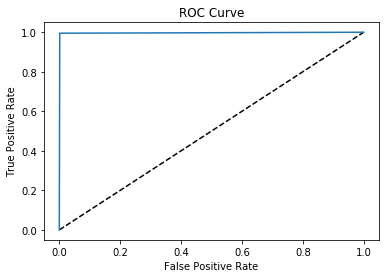

In [64]:
#Probabilities for each prediction output 

target_prob = knn_classifier_scaled.predict_proba(X_test)[:,1]

#Plotting the ROC curve 

fpr, tpr, thresholds = roc_curve(y_test, target_prob)

plt.plot([0,1], [0,1], 'k--')

plt.plot(fpr, tpr)

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.title('ROC Curve')

plt.show()

In [65]:
#Computing the auc score 

roc_auc_score(y_test, target_prob)

0.99681990195235226